### Brightness Distributions
This code calculates and plots the distribution of satellite brightness over the night sky, as seen by a ground-based observer. Several models are included.

In [24]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import lumos.conversions
import lumos.brdf.library
import lumos.calculator
import lumos.plot
import satellite_models.starlink_v1p5 as starlink_v1p5
import satellite_models.diffuse_sphere as diffuse_sphere_model

In [25]:
satellite_height = 550 * 1000

altitudes = np.linspace(0, 90, 45)
azimuths = np.linspace(0, 360, 90)
altitudes, azimuths = np.meshgrid(altitudes, azimuths)

sun_azimuth = 90

In [26]:
def plot_intensity(ax, sun_altitude, surfaces, earth_brdf = None, diffuse_sphere = False, filter = False):

    if diffuse_sphere:
        intensities = diffuse_sphere_model.get_intensity(
            0.65,
            satellite_height,
            altitudes,
            azimuths,
            sun_altitude,
            sun_azimuth)
    else:
        intensities = lumos.calculator.get_intensity_observer_frame(
            surfaces,
            satellite_height,
            altitudes,
            azimuths,
            sun_altitude,
            sun_azimuth,
            include_sun = True,
            include_earthshine = earth_brdf != None,
            earth_panel_density = 251,
            earth_brdf = earth_brdf
        )

    if filter:
        intensities = scipy.ndimage.gaussian_filter(intensities, 2, mode = ('wrap', 'reflect'))

    lumos.plot.contour_observer_frame(
        ax,
        altitudes,
        azimuths,
        lumos.conversions.intensity_to_ab_mag(intensities, clip = True),
        levels = (4, 8),
        cmap = "plasma_r"
    )

    ax.set_title("Sun Altitude" + r"$=$" + f"{sun_altitude}°")

In [27]:
def plot_compass(ax):
    ax.arrow(0, 0, 0, 0.75, width = 0.05, color = "black", head_length = 0.25, head_width = 0.25)
    ax.arrow(0, 0, -0.75, 0, width = 0.05, color = "black", head_length = 0.25, head_width = 0.25)
    ax.scatter([0], [0], s = 350, c = "black", zorder = 1)
    ax.annotate("N", (0, 1.15), horizontalalignment = 'center', 
                    verticalalignment = 'center', fontsize = 24, annotation_clip = False,
                    fontweight = 'bold')
    ax.annotate("E", (-1.15, 0), horizontalalignment = 'center', 
                    verticalalignment = 'center', fontsize = 24, annotation_clip = False,
                    fontweight = 'bold')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

In [28]:
def plot_composite_figure(title, surfaces, earth_brdf = None, diffuse_sphere = False, filter = False):

    fig = plt.figure(figsize = (32, 6), dpi = 300)

    cax = fig.add_axes([0, 0.05, 0.15, 0.75])

    h = 0.8
    w = h * 6 / 32

    ax1 = fig.add_axes([0.5 - w/2 - 2 * (w + 0.0075), 0.025, w, h], projection = 'polar')
    ax2 = fig.add_axes([0.5 - w/2 - 1 * (w + 0.0075), 0.025, w, h], projection = 'polar')
    ax3 = fig.add_axes([0.5 - w/2 + 0 * (w + 0.0075), 0.025, w, h], projection = 'polar')
    ax4 = fig.add_axes([0.5 - w/2 + 1 * (w + 0.0075), 0.025, w, h], projection = 'polar')
    ax5 = fig.add_axes([0.5 - w/2 + 2 * (w + 0.0075), 0.025, w, h], projection = 'polar')
    ax6 = fig.add_axes([0.9, 0, 0.25 * w, 0.25 * h])

    plot_compass(ax6)

    axs = (ax1, ax2, ax3, ax4, ax5)
    sun_altitudes = (-27, -21, -15, -9, -3)

    for ax, sun_alt in zip(axs, sun_altitudes):
        plot_intensity(ax, sun_alt, surfaces, earth_brdf, diffuse_sphere, filter)
        ax.set_title(f"Sun Alt. = {sun_alt}°", y = -0.15, fontsize = 32)
        ax.set_xticklabels(['', '', '', ''])

    fig.suptitle(title, fontsize = 40)

    lumos.plot.colorbar(cax, levels = (4, 8))
    cax.tick_params(labelsize = 28)
    cax.set_ylabel("AB Magnitude", fontsize = 32)
    cax.invert_yaxis()
    cax.yaxis.set_label_position("left")

    plt.show()

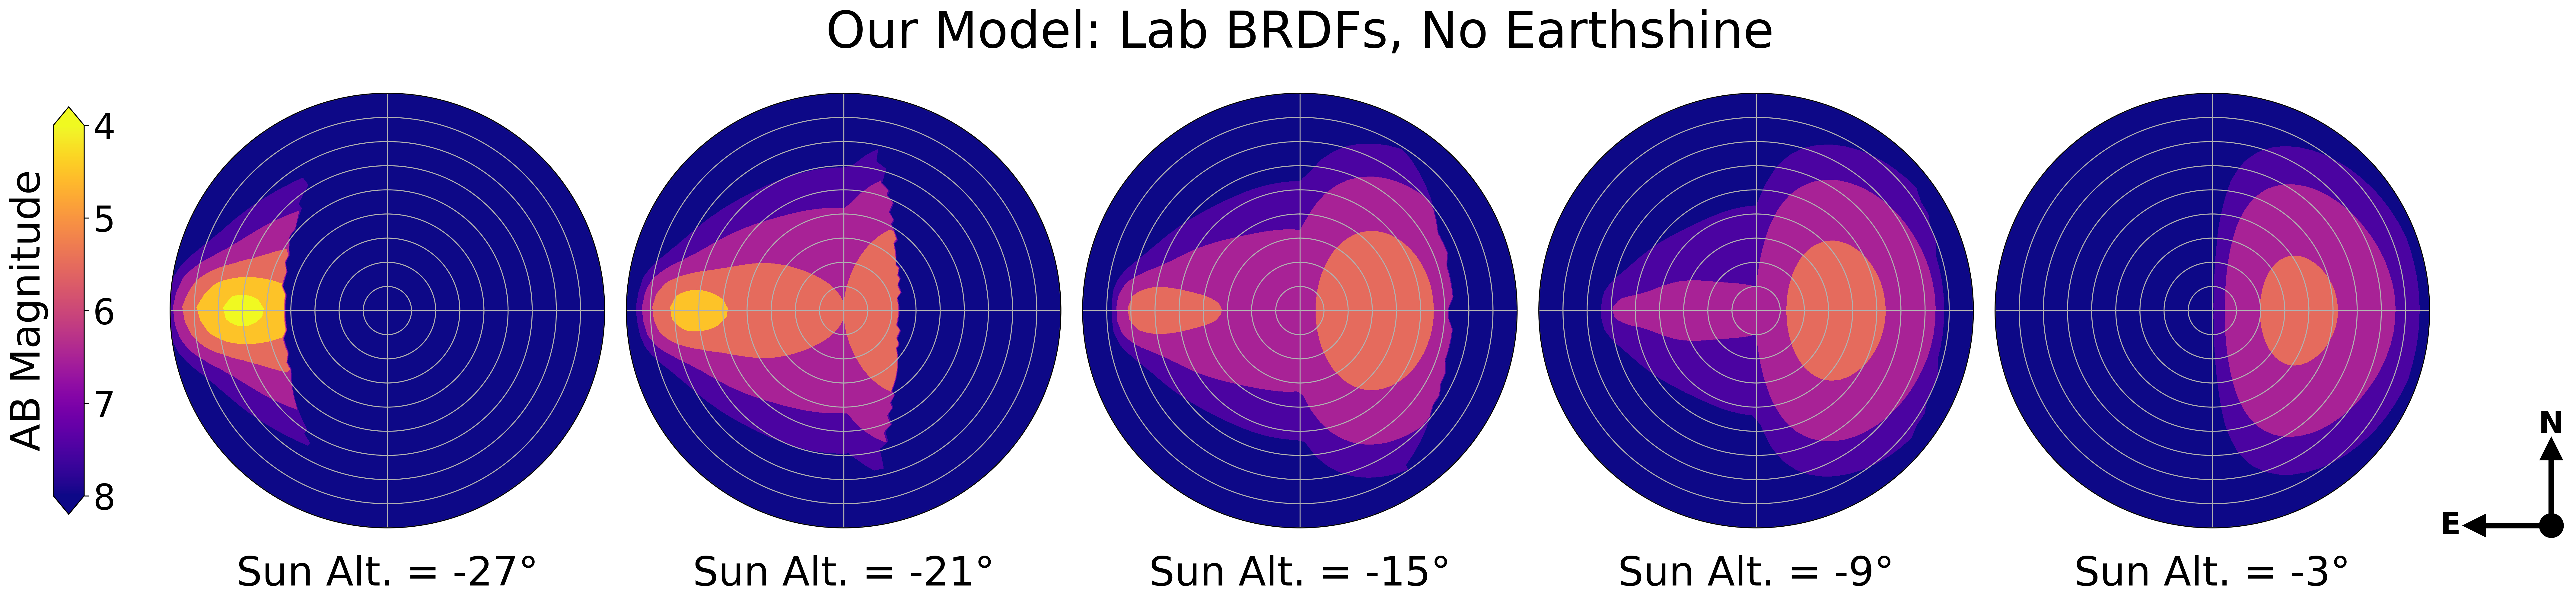

In [29]:
plot_composite_figure(
    title = "Our Model: Lab BRDFs, No Earthshine",
    surfaces = starlink_v1p5.SURFACES_LAB_BRDFS
)

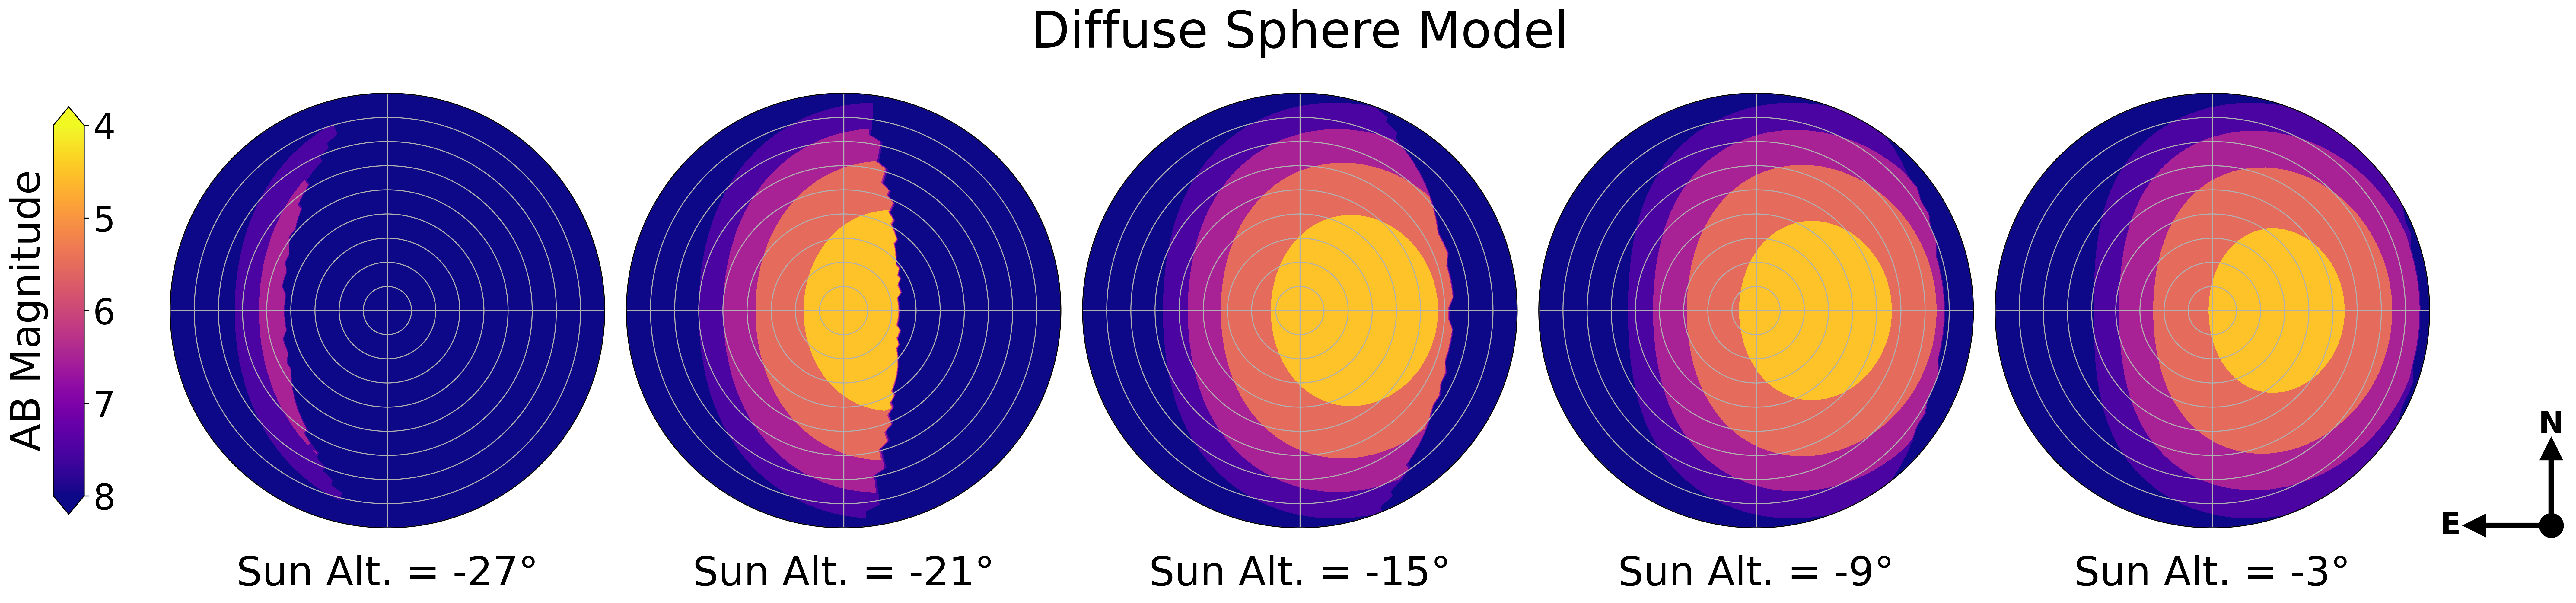

In [30]:
plot_composite_figure(
    "Diffuse Sphere Model",
    surfaces = None,
    diffuse_sphere = True)

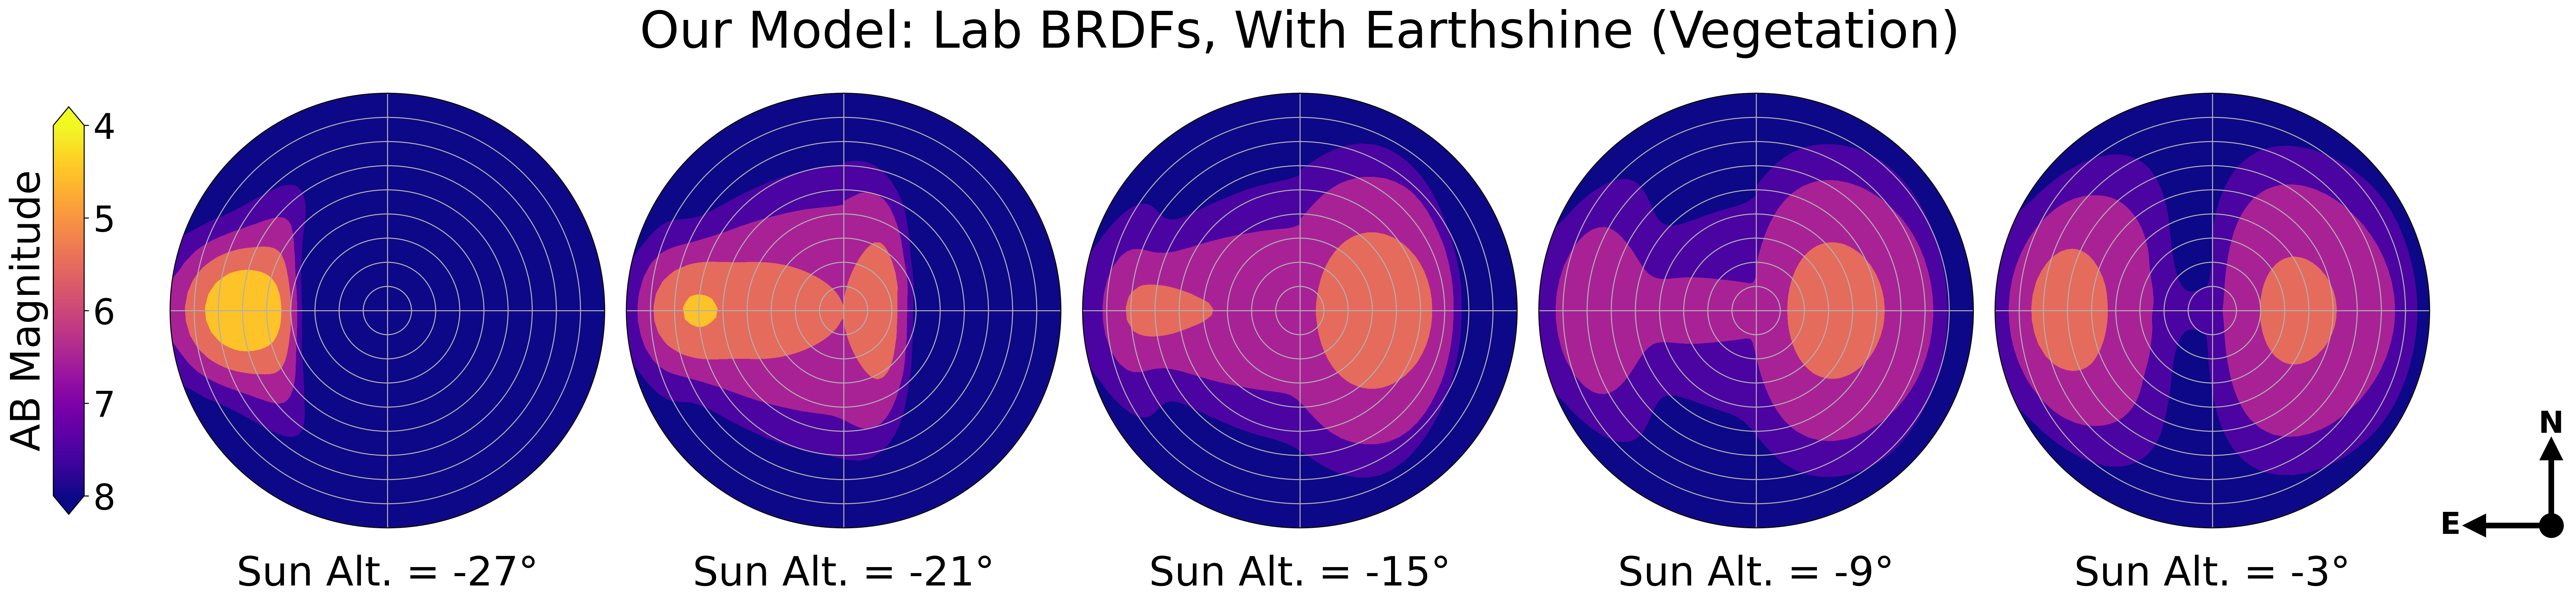

In [31]:
plot_composite_figure(
    "Our Model: Lab BRDFs, With Earthshine (Vegetation)",
    surfaces = starlink_v1p5.SURFACES_LAB_BRDFS,
    earth_brdf = lumos.brdf.library.PHONG(0.53, 0.28, 7.31),
    filter = True
    )

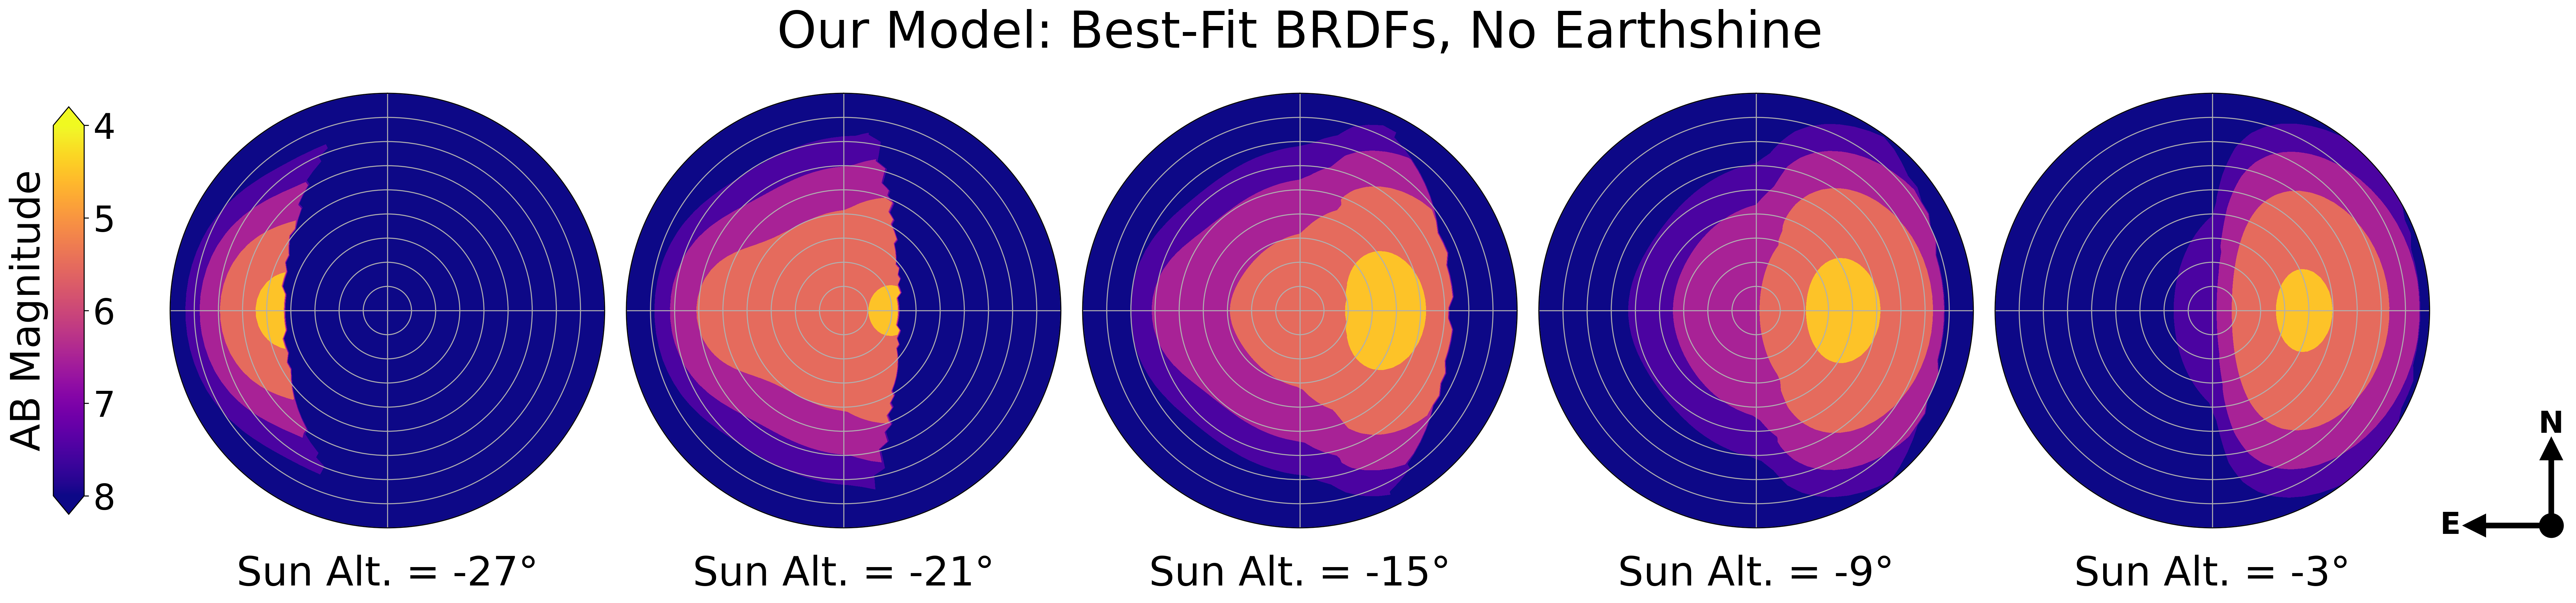

In [32]:
plot_composite_figure(
    title = "Our Model: Best-Fit BRDFs, No Earthshine",
    surfaces = starlink_v1p5.SURFACES_INFER_BRDFS
)